<h1 align="center">Halloween Storm at Japenese Observatories</h1>

In [1]:
import os
import glob

import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use(['seaborn-paper'])

# Local Import
import bezpy

## Reading in the data

1) raw files downloaded from:
  - http://www.kakioka-jma.go.jp/obsdata/metadata/en
  
  and saved in ~/work/data/halloween_storm
  - The time period to download is 10/27/2003 - 11/04/2003
  
2) Then converted to HDF format for ease of use later

In [2]:
# Reading in the raw files, and saving them as HDF to work with later

# Set the file paths appropriately for your own situation
data_directory = "/Users/glucas/work/data/halloween_storm/"

for site in ["kak", "kny", "mmb"]:

    list_of_files = sorted(glob.glob(data_directory + "elec_fields/{0}*dgef.sec".format(site)))
    df_E = pd.concat([bezpy.mag.read_iaga(fname=x) for x in list_of_files]).resample("1s").mean()
    df_E[["X", "Y"]].to_hdf(data_directory + "elec_fields/{0}.hdf".format(site), "Efield")

    # B-fields are in D, H, Z, F
    # But, bezpy automatically converts it to XYZF as a default
    list_of_files = sorted(glob.glob(data_directory + "mag_fields/{0}*dsec.sec".format(site)))
    df_B = pd.concat([bezpy.mag.read_iaga(fname=x) for x in list_of_files]).resample("1s").mean()

    df_B[["X", "Y", "Z"]].to_hdf(data_directory + "mag_fields/{0}.hdf".format(site), "Bfield")

## Now read in those hdf files we just saved

In [3]:
# Reading in the hdf files
kak_E = pd.read_hdf(data_directory + "elec_fields/kak.hdf", "Efield")
kny_E = pd.read_hdf(data_directory + "elec_fields/kny.hdf", "Efield")
mmb_E = pd.read_hdf(data_directory + "elec_fields/mmb.hdf", "Efield")

kak_B = pd.read_hdf(data_directory + "mag_fields/kak.hdf", "Bfield")
kny_B = pd.read_hdf(data_directory + "mag_fields/kny.hdf", "Bfield")
mmb_B = pd.read_hdf(data_directory + "mag_fields/mmb.hdf", "Bfield")

## Interpolate and detrend the data

 - linearly interpolates over missing data
 - detrends the data by removing a constant from each component, change deg=0 to deg=2 or 4 to remove higher order polynomials

In [4]:
kak_E = kak_E.interpolate(limit_direction='both') \
        .apply(lambda x: bezpy.mag.detrend_polynomial(x, deg=0), axis=0)
kny_E = kny_E.interpolate(limit_direction='both') \
        .apply(lambda x: bezpy.mag.detrend_polynomial(x, deg=0), axis=0)
mmb_E = mmb_E.interpolate(limit_direction='both') \
        .apply(lambda x: bezpy.mag.detrend_polynomial(x, deg=0), axis=0)

kak_B = kak_B.interpolate(limit_direction='both') \
        .apply(lambda x: bezpy.mag.detrend_polynomial(x, deg=0), axis=0)
kny_B = kny_B.interpolate(limit_direction='both') \
        .apply(lambda x: bezpy.mag.detrend_polynomial(x, deg=0), axis=0)
mmb_B = mmb_B.interpolate(limit_direction='both') \
        .apply(lambda x: bezpy.mag.detrend_polynomial(x, deg=0), axis=0)

# Plot each Japanese observatory

Download the Japanese observatory site xml files from the IRIS database
 - http://ds.iris.edu/spud/emtf
 
Bezpy automatically parses the xml file, and creates an MT site with routines
for manipulating and investigating the data.

## NOTE:
The estimated impedances are only going down to ~10 seconds for these sites.
The data downloaded was at 1-second, so there is high-frequency content that
can't be represented through the impedances. It would probably make sense to
filter the data first and then run the FFT. This is simply demonstrating some
of the basic functionality of this module, and not how to massage the data.

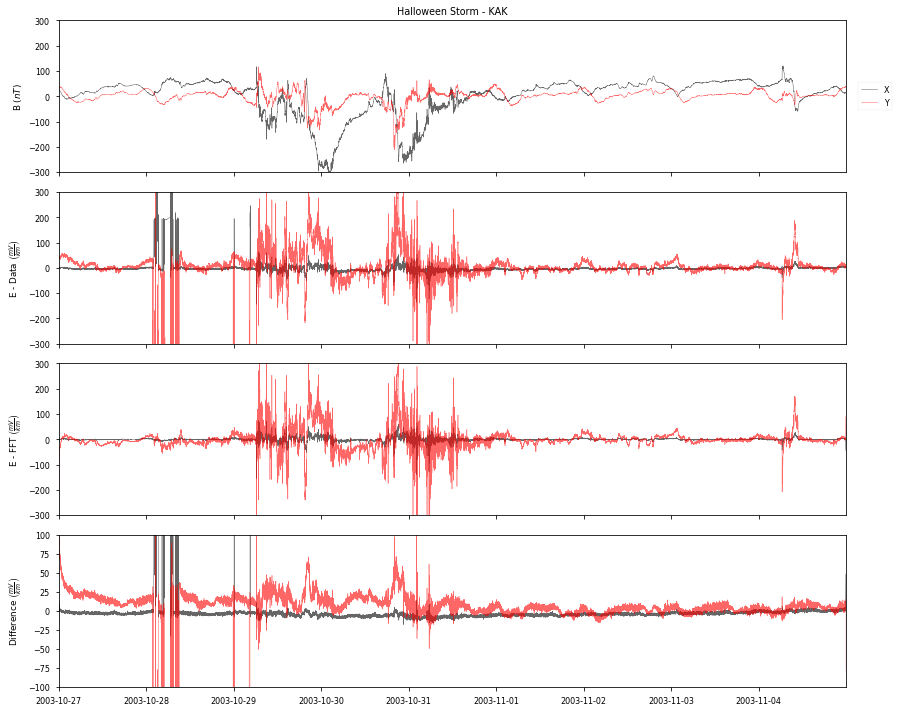

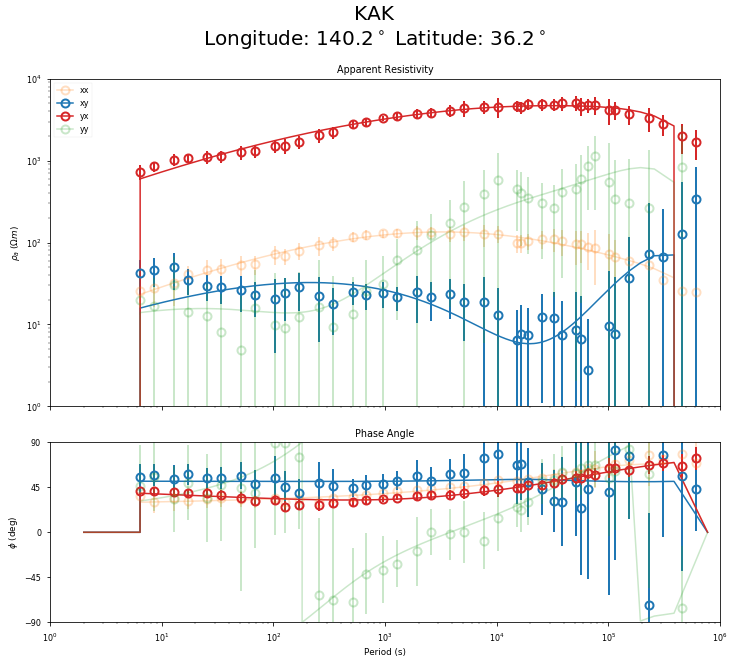

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12,10))

name = 'KAK'
data_B = kak_B
data_E = kak_E
MT_file = data_directory + "MT_sites/" + \
          "MT_TF_INTERMAGNET.{0}.2000-2011/INTERMAGNET.{0}.2000-2011.xml".format(name)
site = bezpy.mt.read_xml(MT_file)


ax1.plot(data_B.index, data_B["X"], c='k', alpha=0.6, lw=0.5, label='X')
ax1.plot(data_B.index, data_B["Y"], c='r', alpha=0.6, lw=0.5, label='Y')
ax1.legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
ax1.set(xlim=[data_B.index[0], data_B.index[-1]],
        ylim=[-300, 300],
        ylabel=r'B $(nT)$',
        title='Halloween Storm - {site}'.format(site=name))

ax1.xaxis.set_major_locator(mpl.dates.HourLocator(interval=24))
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter("%m-%d"))

ax2.plot(data_E.index, data_E["X"], c='k', alpha=0.6, lw=0.5, label='X')
ax2.plot(data_E.index, data_E["Y"], c='r', alpha=0.6, lw=0.5, label='Y')
ax2.set(ylim=[-300, 300],
        ylabel=r'E - Data $\left(\frac{mV}{km}\right)$')


# Do a convolution at the site
Ex, Ey = site.convolve_fft(data_B["X"], data_B["Y"], dt=1)

ax3.plot(data_E.index, Ex, c='k', alpha=0.6, lw=0.5, label='X')
ax3.plot(data_E.index, Ey, c='r', alpha=0.6, lw=0.5, label='Y')
ax3.set(ylim=[-300, 300],
        ylabel=r'E - FFT $\left(\frac{mV}{km}\right)$')

# Do a difference of the convolution and the real data
ax4.plot(data_E.index, data_E['X']-Ex, c='k', alpha=0.6, lw=0.5, label='X')
ax4.plot(data_E.index, data_E['Y']-Ey, c='r', alpha=0.6, lw=0.5, label='Y')
ax4.set(ylim=[-100, 100],
        ylabel=r'Difference $\left(\frac{mV}{km}\right)$')
plt.tight_layout()

site.plot_apparent_resistivity(interp_freqs=np.fft.rfftfreq(len(data_B), d=1));

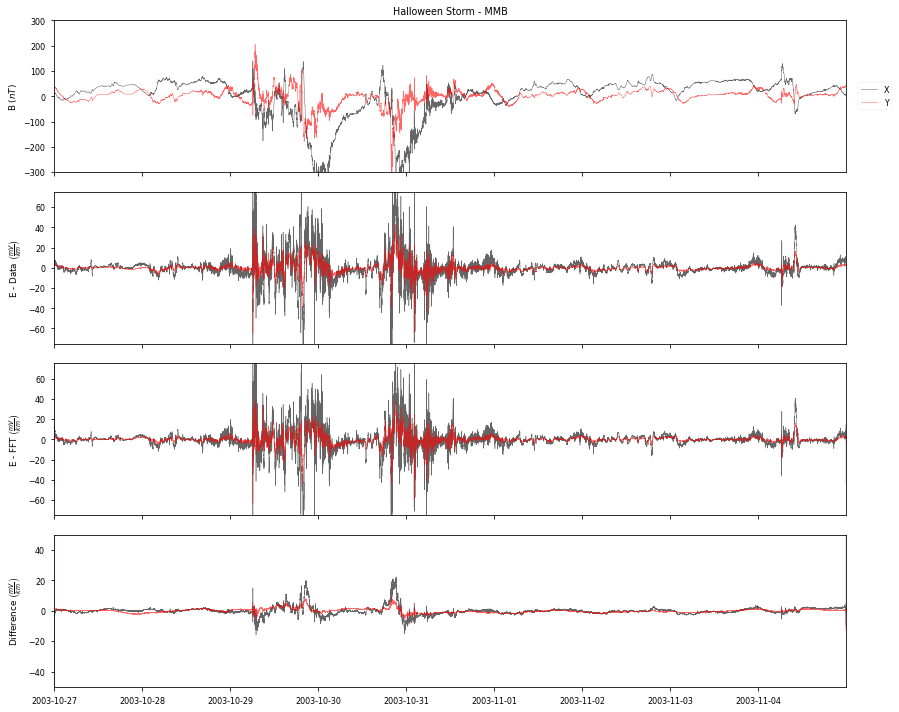

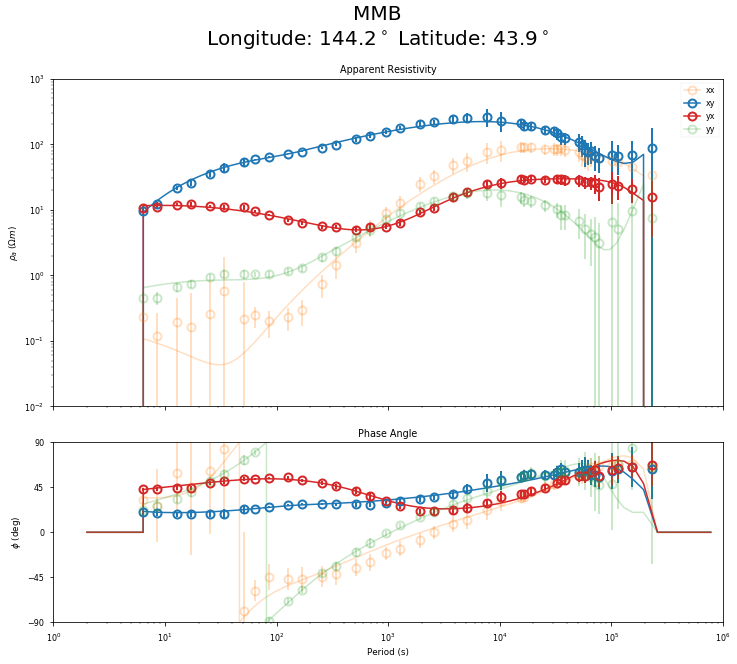

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12,10))


name = 'MMB'
data_B = mmb_B
data_E = mmb_E
MT_file = data_directory + "MT_sites/" + \
          "MT_TF_INTERMAGNET.{0}.2000-2011/INTERMAGNET.{0}.2000-2011.xml".format(name)
site = bezpy.mt.read_xml(MT_file)


ax1.plot(data_B.index, data_B["X"], c='k', alpha=0.6, lw=0.5, label='X')
ax1.plot(data_B.index, data_B["Y"], c='r', alpha=0.6, lw=0.5, label='Y')
ax1.legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
ax1.set(xlim=[data_B.index[0], data_B.index[-1]],
        ylim=[-300, 300],
        ylabel=r'B $(nT)$',
        title='Halloween Storm - {site}'.format(site=name))

ax1.xaxis.set_major_locator(mpl.dates.HourLocator(interval=24))
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter("%m-%d"))

ax2.plot(data_E.index, data_E["X"], c='k', alpha=0.6, lw=0.5, label='X')
ax2.plot(data_E.index, data_E["Y"], c='r', alpha=0.6, lw=0.5, label='Y')
ax2.set(ylim=[-75, 75],
        ylabel=r'E - Data $\left(\frac{mV}{km}\right)$')


# Do a convolution at the site
Ex, Ey = site.convolve_fft(data_B["X"], data_B["Y"], dt=1)

ax3.plot(data_E.index, Ex, c='k', alpha=0.6, lw=0.5, label='X')
ax3.plot(data_E.index, Ey, c='r', alpha=0.6, lw=0.5, label='Y')
ax3.set(ylim=[-75, 75],
        ylabel=r'E - FFT $\left(\frac{mV}{km}\right)$')

# Do a difference of the convolution and the real data
ax4.plot(data_E.index, data_E['X']-Ex, c='k', alpha=0.6, lw=0.5, label='X')
ax4.plot(data_E.index, data_E['Y']-Ey, c='r', alpha=0.6, lw=0.5, label='Y')
ax4.set(ylim=[-50, 50],
        ylabel=r'Difference $\left(\frac{mV}{km}\right)$')
plt.tight_layout()

site.plot_apparent_resistivity(interp_freqs=np.fft.rfftfreq(len(data_B), d=1));

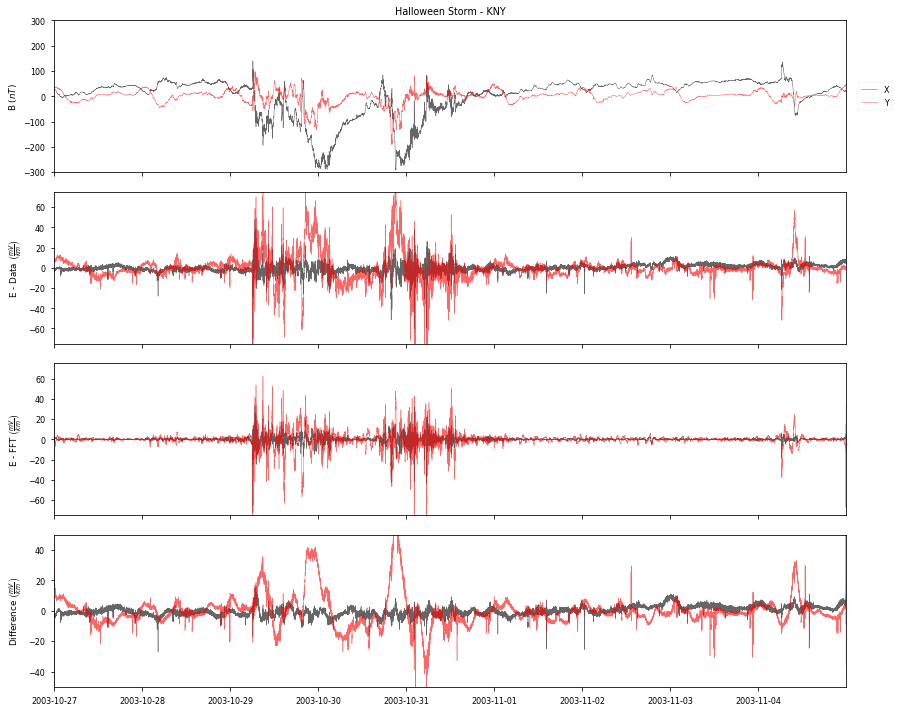

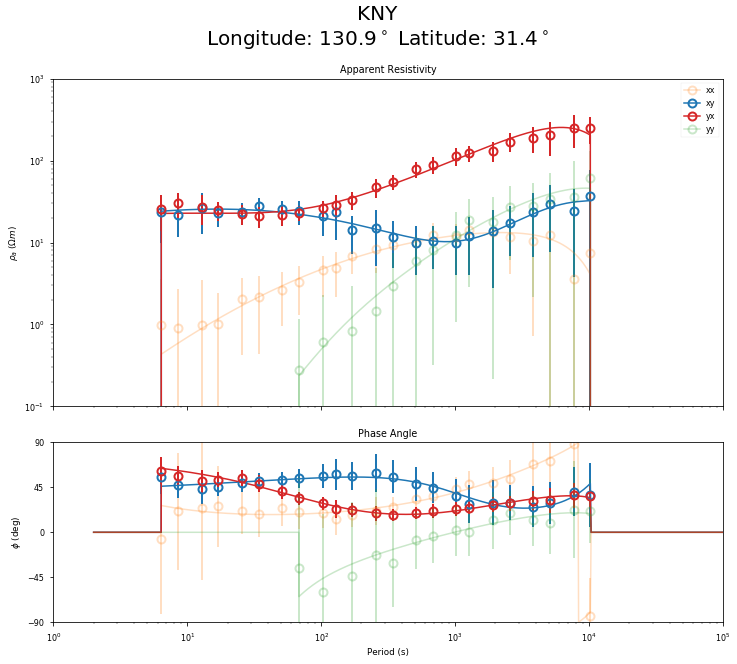

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12,10))

name = 'KNY'
data_B = kny_B
data_E = kny_E
MT_file = data_directory + "MT_sites/" + \
          "MT_TF_INTERMAGNET.{0}.2000-2011/INTERMAGNET.{0}.2000-2011.xml".format(name)
site = bezpy.mt.read_xml(MT_file)


ax1.plot(data_B.index, data_B["X"], c='k', alpha=0.6, lw=0.5, label='X')
ax1.plot(data_B.index, data_B["Y"], c='r', alpha=0.6, lw=0.5, label='Y')
ax1.legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
ax1.set(xlim=[data_B.index[0], data_B.index[-1]],
        ylim=[-300, 300],
        ylabel=r'B $(nT)$',
        title='Halloween Storm - {site}'.format(site=name))

ax1.xaxis.set_major_locator(mpl.dates.HourLocator(interval=24))
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter("%m-%d"))

ax2.plot(data_E.index, data_E["X"], c='k', alpha=0.6, lw=0.5, label='X')
ax2.plot(data_E.index, data_E["Y"], c='r', alpha=0.6, lw=0.5, label='Y')
ax2.set(ylim=[-75, 75],
        ylabel=r'E - Data $\left(\frac{mV}{km}\right)$')


# Do a convolution at the site
Ex, Ey = site.convolve_fft(data_B["X"], data_B["Y"], dt=1)

ax3.plot(data_E.index, Ex, c='k', alpha=0.6, lw=0.5, label='X')
ax3.plot(data_E.index, Ey, c='r', alpha=0.6, lw=0.5, label='Y')
ax3.set(ylim=[-75, 75],
        ylabel=r'E - FFT $\left(\frac{mV}{km}\right)$')

# Do a difference of the convolution and the real data
ax4.plot(data_E.index, data_E['X']-Ex, c='k', alpha=0.6, lw=0.5, label='X')
ax4.plot(data_E.index, data_E['Y']-Ey, c='r', alpha=0.6, lw=0.5, label='Y')
ax4.set(ylim=[-50, 50],
        ylabel=r'Difference $\left(\frac{mV}{km}\right)$')
plt.tight_layout()

site.plot_apparent_resistivity(interp_freqs=np.fft.rfftfreq(len(data_B), d=1));